# Phase 4: Model Pruning Experiments

Finding the limit of efficiency. Can we prune the ensemble size of **TabM** without losing too much accuracy?

### Models to Test:
1. **TabM (K=4)**: Current Champion (0.17ms, ~0.923 AUC).
2. **TabM (K=2)**: 50% fewer parameters in the ensemble layer.
3. **TabM (K=1)**: No ensemble layer (essentially a single efficient MLP).

---

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
import os
import joblib
import onnxruntime as ort

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using Device: {DEVICE}")

DATA_PATH = "../data/raw/online_shoppers_intention.csv"
MODELS_PATH = "../backend/models"
os.makedirs(MODELS_PATH, exist_ok=True)

🔥 Using Device: cpu


## 1. Data Pipeline (Reused)

In [2]:
# Reuse the exact same preprocessing for fair comparison
def load_and_preprocess():
    df = pd.read_csv(DATA_PATH)
    y = df['Revenue'].astype(int).values
    cat_cols = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
    num_cols = [c for c in df.columns if c not in cat_cols and c != 'Revenue']
    
    X_cat = np.zeros((len(df), len(cat_cols)), dtype=np.int64)
    cat_dims = []
    for i, col in enumerate(cat_cols):
        le = LabelEncoder()
        X_cat[:, i] = le.fit_transform(df[col].astype(str))
        cat_dims.append(len(le.classes_))
        
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_cols].astype(float))
    return X_cat, X_num, y, cat_dims, X_num.shape[1]

X_c, X_n, y, cat_dims, num_dim = load_and_preprocess()

# Split
indices = np.arange(len(y))
Xc_tr, Xc_temp, Xn_tr, Xn_temp, y_tr, y_temp, idx_tr, idx_temp = train_test_split(X_c, X_n, y, indices, test_size=0.2, stratify=y, random_state=42)
Xc_val, Xc_test, Xn_val, Xn_test, y_val, y_test = train_test_split(Xc_temp, Xn_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Tensors
def to_tensor(xc, xn, y_):
    return torch.tensor(xc, dtype=torch.long), torch.tensor(xn, dtype=torch.float32), torch.tensor(y_, dtype=torch.float32)

full_data = {
    'train': to_tensor(Xc_tr, Xn_tr, y_tr),
    'val': to_tensor(Xc_val, Xn_val, y_val),
    'test': to_tensor(Xc_test, Xn_test, y_test)
}
print("✅ Data Loaded & Split")

✅ Data Loaded & Split


## 2. Model Definitions

In [3]:
class FeatureEmbedding(nn.Module):
    def __init__(self, cat_dims, embed_dim):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(d, embed_dim) for d in cat_dims
        ])
    def forward(self, x_cat):
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        return torch.stack(embedded, dim=1)

class TabM(nn.Module):
    def __init__(self, cat_dims, num_dim, hidden_dim=128, n_ensemble=4):
        super().__init__()
        self.n_ensemble = n_ensemble
        self.embedding = FeatureEmbedding(cat_dims, embed_dim=4)
        input_dim = (len(cat_dims) * 4) + num_dim
        
        self.bn_in = nn.BatchNorm1d(input_dim)
        
        # Ensemble Blocks
        self.ensemble_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.GELU(),
            ) for _ in range(n_ensemble)
        ])
        self.heads = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(n_ensemble)
        ])
        
    def forward(self, x_cat, x_num):
        emb_cat = self.embedding(x_cat).flatten(1)
        x_in = torch.cat([emb_cat, x_num], dim=1)
        x_in = self.bn_in(x_in)
        
        outputs = [head(block(x_in)) for block, head in zip(self.ensemble_blocks, self.heads)]
        stacked = torch.stack(outputs, dim=0)
        return stacked.mean(dim=0)

## 3. Training Loop

In [4]:
def train_model(model, name, epochs=30, batch_size=256):
    model = model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    dataset = TensorDataset(*full_data['train'])
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    best_auc = 0
    training_time = 0
    start_time = time.time()
    
    print(f"\n🚀 Training {name}...")
    for epoch in range(epochs):
        model.train()
        for xc, xn, y in loader:
            xc, xn, y = xc.to(DEVICE), xn.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(xc, xn).squeeze()
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
        scheduler.step()
        
        # Val
        model.eval()
        with torch.no_grad():
            xc_v, xn_v, y_v = [t.to(DEVICE) for t in full_data['val']]
            val_out = model(xc_v, xn_v).squeeze()
            val_auc = roc_auc_score(y_v.cpu().numpy(), torch.sigmoid(val_out).cpu().numpy())
            
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), f"{MODELS_PATH}/{name}.pth")
            
    training_time = time.time() - start_time
    print(f"✅ {name} Done. Best Validation AUC: {best_auc:.4f} | Time: {training_time:.2f}s")
    return best_auc

## 4. Run Experiments (K=4 vs K=2 vs K=1)

In [5]:
results = {}

# K=4 (Baseline)
model_k4 = TabM(cat_dims, num_dim, n_ensemble=4)
auc_k4 = train_model(model_k4, "tabm_k4", epochs=20)
results['K=4'] = auc_k4

# K=2 (Pruned)
model_k2 = TabM(cat_dims, num_dim, n_ensemble=2)
auc_k2 = train_model(model_k2, "tabm_k2", epochs=20)
results['K=2'] = auc_k2

# K=1 (Single MLP)
model_k1 = TabM(cat_dims, num_dim, n_ensemble=1)
auc_k1 = train_model(model_k1, "tabm_k1", epochs=20)
results['K=1'] = auc_k1

print("\n🏆 Accuracy Results:", results)


🚀 Training tabm_k4...
✅ tabm_k4 Done. Best Validation AUC: 0.9191 | Time: 24.94s

🚀 Training tabm_k2...
✅ tabm_k2 Done. Best Validation AUC: 0.9239 | Time: 13.45s

🚀 Training tabm_k1...
✅ tabm_k1 Done. Best Validation AUC: 0.9276 | Time: 10.31s

🏆 Accuracy Results: {'K=4': 0.9191245188974083, 'K=2': 0.9238677131171429, 'K=1': 0.9276260915878647}


## 5. Export to ONNX & Latency Benchmark

In [6]:
def export_and_benchmark(model_name, n_ensemble):
    # Load best weights
    model = TabM(cat_dims, num_dim, n_ensemble=n_ensemble)
    model.load_state_dict(torch.load(f"{MODELS_PATH}/{model_name}.pth"))
    model.eval()
    
    # Export
    dummy_cat = torch.zeros((1, len(cat_dims)), dtype=torch.long)
    dummy_num = torch.randn((1, num_dim), dtype=torch.float32)
    onnx_path = f"{MODELS_PATH}/{model_name}.onnx"
    
    # FIXED: Use unique input names to avoid conflicts
    torch.onnx.export(
        model,
        (dummy_cat, dummy_num),
        onnx_path,
        input_names=['input_cat', 'input_num'],
        output_names=['output'],
        dynamic_axes={'input_cat': {0: 'batch'}, 'input_num': {0: 'batch'}, 'output': {0: 'batch'}}
    )
    
    # Benchmark ONNX
    sess = ort.InferenceSession(onnx_path)
    inp = {'input_cat': dummy_cat.numpy(), 'input_num': dummy_num.numpy()}
    
    latencies = []
    # Warmup
    for _ in range(100): sess.run(None, inp)
    # Measure
    for _ in range(1000):
        start = time.perf_counter()
        sess.run(None, inp)
        latencies.append((time.perf_counter() - start) * 1000)
        
    return np.mean(latencies)

latency_k4 = export_and_benchmark("tabm_k4", 4)
latency_k2 = export_and_benchmark("tabm_k2", 2)
latency_k1 = export_and_benchmark("tabm_k1", 1)

print(f"\n⚡ Latency (ONNX):\n  K=4: {latency_k4:.4f} ms\n  K=2: {latency_k2:.4f} ms\n  K=1: {latency_k1:.4f} ms")

C:\Users\khair\AppData\Local\Temp\ipykernel_17928\315736654.py:13: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0201 17:33:57.403000 17928 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::nms
W0201 17:33:57.406000 17928 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::roi_align
W0201 17:33:57.409000 17928 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::roi_pool


[torch.onnx] Obtain model graph for `TabM([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `TabM([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


C:\Program Files\Python310\lib\copyreg.py:101: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


d:\op_ecom\venv\lib\site-packages\torch\onnx\_internal\exporter\_onnx_program.py:460: UserWarning: # The axis name: batch will not be used, since it shares the same shape constraints with another axis: batch.
  rename_mapping = _dynamic_shapes.create_rename_mapping(


Applied 16 of general pattern rewrite rules.


C:\Users\khair\AppData\Local\Temp\ipykernel_17928\315736654.py:13: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0201 17:34:02.581000 17928 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::nms
W0201 17:34:02.587000 17928 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::roi_align
W0201 17:34:02.590000 17928 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::roi_pool


[torch.onnx] Obtain model graph for `TabM([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `TabM([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


C:\Program Files\Python310\lib\copyreg.py:101: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


d:\op_ecom\venv\lib\site-packages\torch\onnx\_internal\exporter\_onnx_program.py:460: UserWarning: # The axis name: batch will not be used, since it shares the same shape constraints with another axis: batch.
  rename_mapping = _dynamic_shapes.create_rename_mapping(


Applied 12 of general pattern rewrite rules.


C:\Users\khair\AppData\Local\Temp\ipykernel_17928\315736654.py:13: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0201 17:34:05.909000 17928 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::nms
W0201 17:34:05.910000 17928 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::roi_align
W0201 17:34:05.914000 17928 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::roi_pool


[torch.onnx] Obtain model graph for `TabM([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `TabM([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


C:\Program Files\Python310\lib\copyreg.py:101: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


d:\op_ecom\venv\lib\site-packages\torch\onnx\_internal\exporter\_onnx_program.py:460: UserWarning: # The axis name: batch will not be used, since it shares the same shape constraints with another axis: batch.
  rename_mapping = _dynamic_shapes.create_rename_mapping(


Applied 10 of general pattern rewrite rules.

⚡ Latency (ONNX):
  K=4: 0.1065 ms
  K=2: 0.0913 ms
  K=1: 0.0920 ms


## 6. Efficiency Frontier Plot

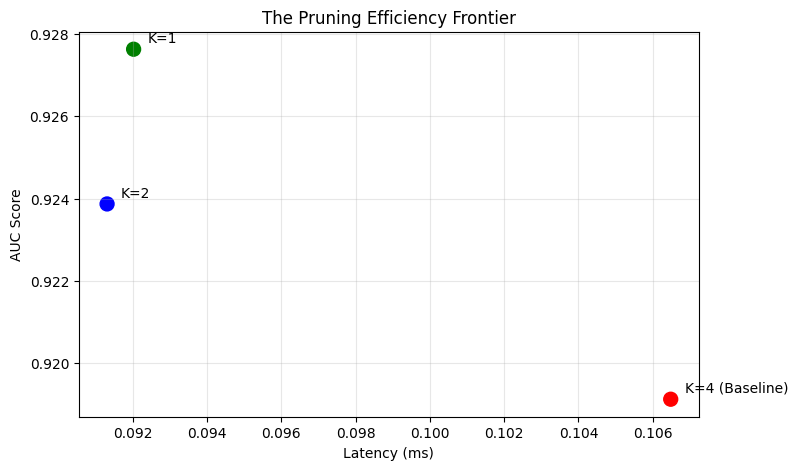

In [7]:
plt.figure(figsize=(8, 5))

accuracies = [results['K=4'], results['K=2'], results['K=1']]
latencies = [latency_k4, latency_k2, latency_k1]
labels = ['K=4 (Baseline)', 'K=2', 'K=1']

plt.scatter(latencies, accuracies, s=100, c=['red', 'blue', 'green'])
for i, label in enumerate(labels):
    plt.annotate(label, (latencies[i], accuracies[i]), xytext=(10, 5), textcoords='offset points')
    
plt.xlabel("Latency (ms)")
plt.ylabel("AUC Score")
plt.title("The Pruning Efficiency Frontier")
plt.grid(True, alpha=0.3)
plt.show()